## The Research Example in Chapter 8, Section 7: Handling Astronomical Images

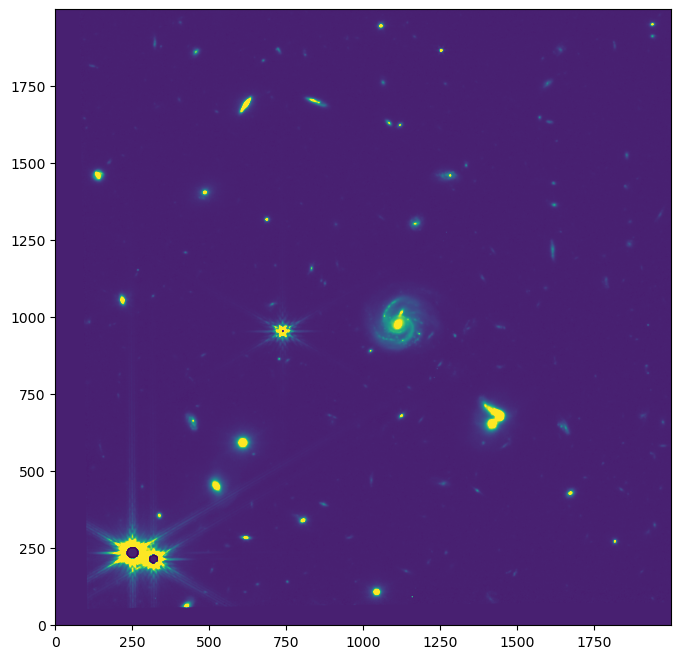

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# open the file
with fits.open('../../BookDatasets/HST_JWST/jwst_f277W_crop.fits') as hdu:
    image = hdu[0].data
    header = hdu[0].header

s = 5
vmin = np.median(image) - 0.5 * np.std(image)
vmax = np.mean(image) - np.median(image) + s * np.std(image)

fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(image, vmin=vmin, vmax=vmax, origin='lower');

#### Exercise 8.3 is in Problem Set 4

In [2]:
### Plate-Solving

from astropy.wcs import WCS

im_wcs = WCS(header)

Set OBSGEO-B to   -36.849188 from OBSGEO-[XYZ].
Set OBSGEO-H to 1725785823.910 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


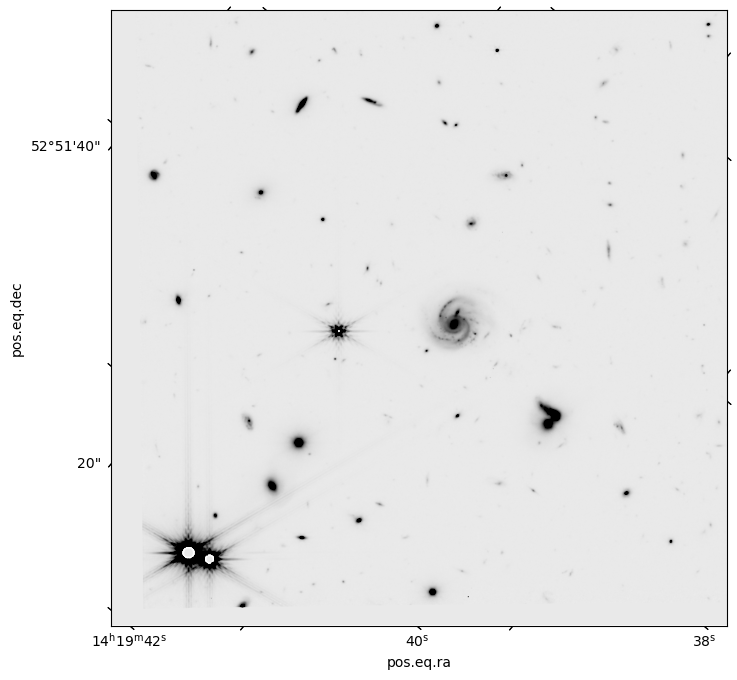

In [3]:
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'projection': im_wcs})
ax.imshow(image, vmin=vmin, vmax=vmax, cmap='gray_r');

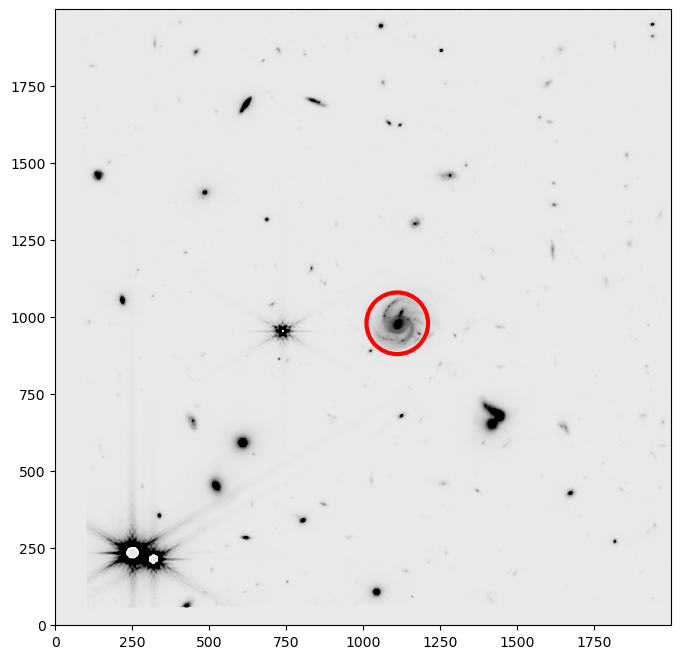

In [4]:
### Circular Aperture

from photutils.aperture import CircularAperture

# define pixel aperture
aperture = CircularAperture([1110, 980], r=100)

fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(image, vmin=vmin, vmax=vmax, cmap='gray_r', origin='lower')
aperture.plot(color='r', lw=3);

In [5]:
aperture.to_sky(im_wcs)

<SkyCircularAperture(<SkyCoord (ICRS): (ra, dec) in deg
    (214.9052996, 52.85095396)>, r=2.999998303351201 arcsec)>

In [6]:
coord = aperture.to_sky(im_wcs).positions
coord.to_string('hmsdms')

'14h19m37.27190414s +52d51m03.43427078s'

In [7]:
### Image Cutouts

from astropy.nddata import Cutout2D
import astropy.units as u

cutout = Cutout2D(data=image,
                  position=coord,
                  size=12*u.arcsec,
                  wcs=im_wcs)

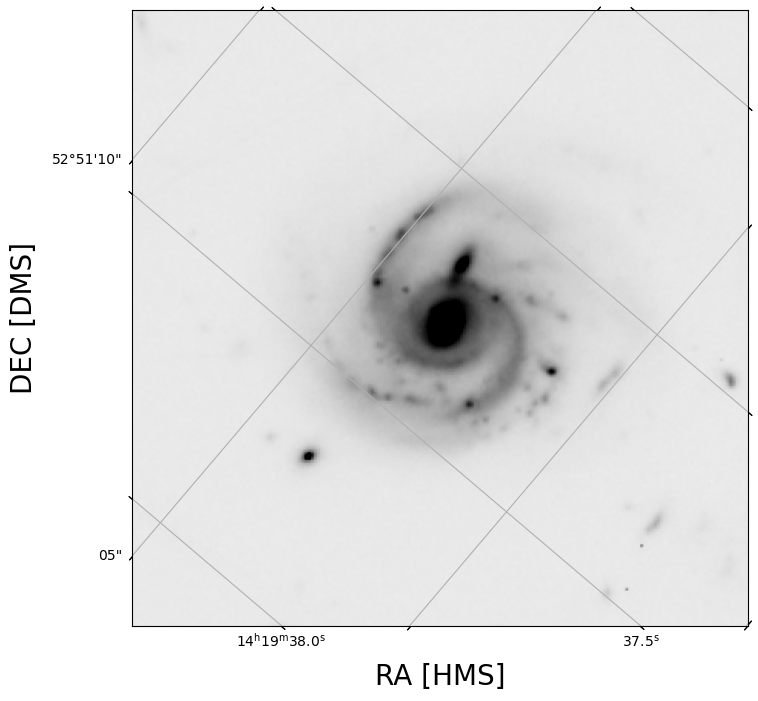

In [8]:
fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'projection':cutout.wcs})
ax.imshow(cutout.data, vmin=vmin, vmax=vmax, cmap='gray_r')
ax.set_xlabel('RA [HMS]', fontsize=20)
ax.set_ylabel('DEC [DMS]', fontsize=20)
ax.grid()

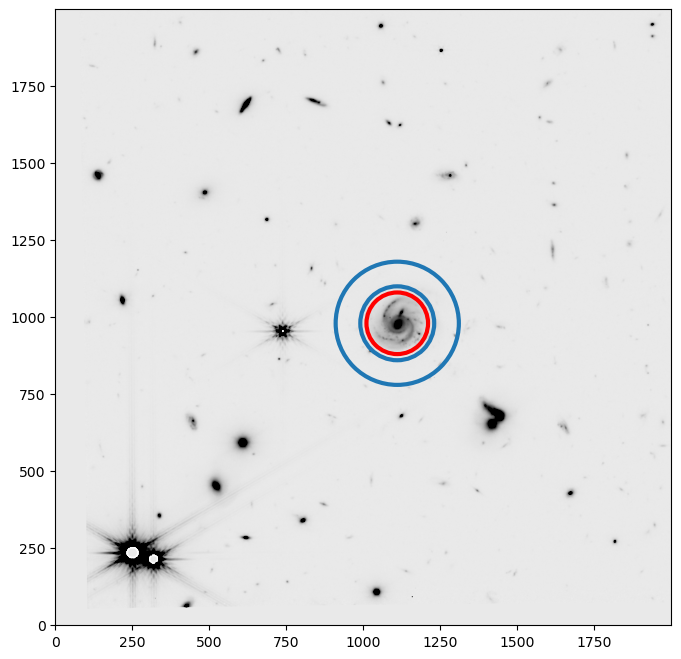

In [9]:
### Aperture Photometry

from photutils.aperture import CircularAnnulus

aperture = CircularAperture([1110, 980], r=100)
bg_aperture = CircularAnnulus([1110, 980], r_in=120, r_out=200)

fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(image, vmin=vmin, vmax=vmax, cmap='gray_r', origin='lower')
aperture.plot(color='r', lw=3)
bg_aperture.plot(color='C0', lw=3);

In [10]:
from photutils.aperture import ApertureStats, aperture_photometry

phot_table = aperture_photometry(image, aperture)
flux = phot_table['aperture_sum'][0]
bg_stats = ApertureStats(image, bg_aperture)
bkg_mean = bg_stats.mean
print(flux)
print(bkg_mean)

8312.259999858908
0.0074764478284599645


In [11]:
print(f'Aperture Area: {aperture.area:.4f}')

final_flux = flux - bkg_mean * aperture.area
print(f'Final flux measurement: {final_flux:.3f}')

Aperture Area: 31415.9265
Final flux measurement: 8077.380


In [12]:
### Combining Images

def load_and_cutout(band_name, coord, size):
    with fits.open(f'../../BookDatasets/HST_JWST/jwst_{band_name}_crop.fits') as hdu:
        image = hdu[0].data
        wcs = WCS(hdu[0].header)
        cutout = Cutout2D(data=image,
                          position=coord,
                          size=size,
                          wcs=wcs)
        return cutout

f150w = load_and_cutout('f150W', coord=coord, size=12*u.arcsec)
f277w = load_and_cutout('f277W', coord=coord, size=12*u.arcsec)
f444w = load_and_cutout('f444W', coord=coord, size=12*u.arcsec)

Set OBSGEO-B to   -36.864348 from OBSGEO-[XYZ].
Set OBSGEO-H to 1725861996.312 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -36.849188 from OBSGEO-[XYZ].
Set OBSGEO-H to 1725785823.910 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -36.871979 from OBSGEO-[XYZ].
Set OBSGEO-H to 1725899961.594 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


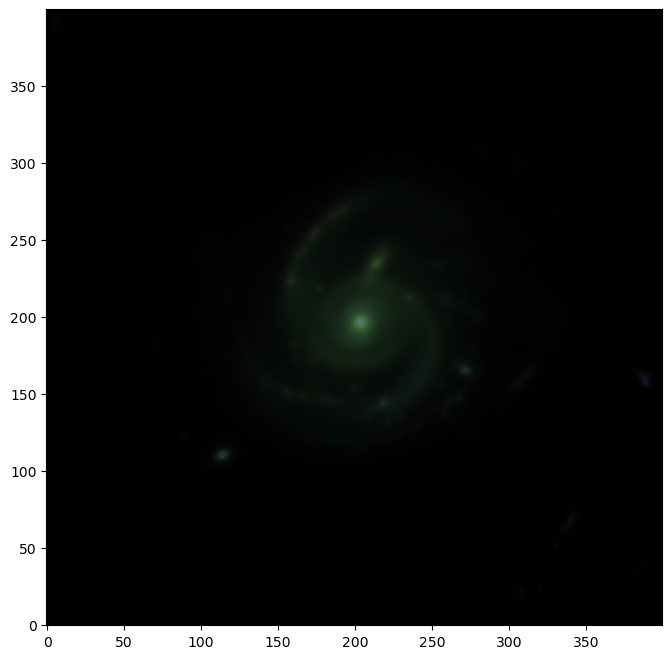

In [13]:
from astropy.visualization import make_lupton_rgb

rgb_image = make_lupton_rgb(f444w.data, f277w.data, f150w.data)

fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(rgb_image, origin='lower');

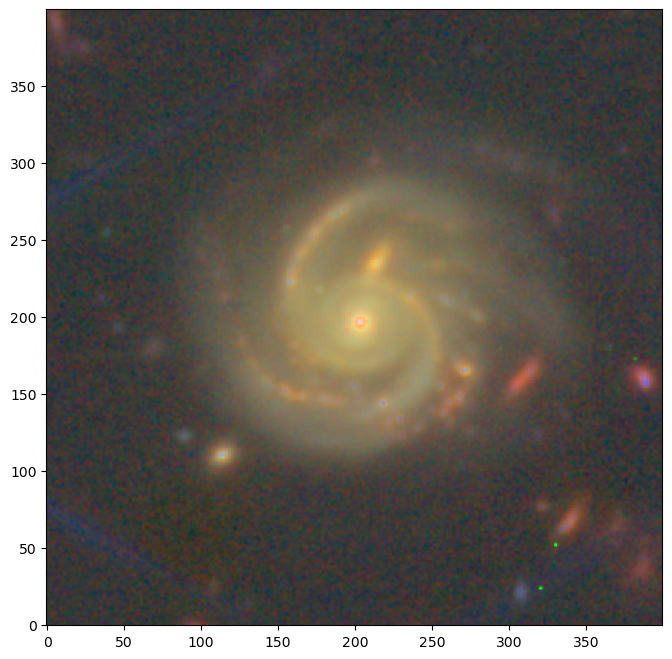

In [14]:
rgb_image = make_lupton_rgb(2.0 * f444w.data, f277w.data, f150w.data,
                            minimum=np.mean(f277w.data)-0.5 * np.std(f277w.data),
                            stretch=0.1,
                            Q=9)

fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(rgb_image, origin='lower');